# Introduction to Data Science, Lab 12 (12/02)
 - Overview of Graphical Models;
 - Restricted Boltzmann Machines as Graphical Models;
 - Markov Chain Monte Carlo (MCMC) methods for training RBMs;
 - A MNIST database example with scikit-learn's Bernoulli RBMs.
 
The material in this notebook is inspired by [Hugo Larochelle's](https://www.youtube.com/watch?v=p4Vh_zMw-HQ) video series and [Christian Igel's tutorial](https://christian-igel.github.io/paper/TRBMAI.pdf).

## *Graphical Models*

#### *Definition*
Probabilistic graphical models consist of a graph $G=(V,E)$ (directed or undirected) and a joint probability distribution $P$ of some $|V|$ random variables $X_1,X_2,\ldots,X_{|V|}$ that respects independence properties present in $G$. Random variables $X_i$ need not be identically distributed, though it is usually required that they have the same range $\mathcal{X}$. Two main subdivisions of graphical models are *Bayesian neworks* (directed) and *Markov Random Fields* (undirected). Boltzmann Machines are instances of the latter, so we discuss them in more detail.

A distribution $P$ satisfies the local Markov property with respect to $G$ if $X_i\perp X^{(i)}\colon N(X_i)$, where $N(i)=\{X_j\colon [i,j]\in E\}$ is the set of variables associated with vertices of $G$ incident to $i$, and $X^{(i)}=\{X_j\colon X_j\notin N(i),i\ne j\}$ are all other variables other that $X_i$ itself. In this case, $(G,P)$ form a *Markov Random Field*.

#### *Gibbs distribution*
A joint distribution $P$ of random variables $\mathbf{X}=\{X_1,X_2\ldots,X_n\}$ is a *Gibbs distribution parametrized by $\Psi$* if for some $k\in\mathbb{Z}$, some $D_1,D_2,\ldots,D_k\subseteq\mathbf{X}$ and a collection of non-negative functions $\Psi=\{\psi_1,\psi_2,\ldots,\psi_k\}$ where $\psi_i\colon\text{Val}(D_i)\rightarrow\mathbb{R}$. we have

$$
P(\mathbf{x})=\frac{\prod_{i=1}^{k}\psi_i(\mathbf{x}_{D_i})}{\sum_{\mathbf{x}}\prod_{i=1}^{k}\psi_i(\mathbf{x}_{D_{i}})}=\frac{1}{Z}\prod_{i=1}^{k}\psi_i(\mathbf{x}_{D_i})
$$

for any $\mathbf{x}\in\text{Val}(\mathbf{X})$. Note that $\mathbf{x}_{D_i}$ denotes the $|D_i|$-dimensional vector obtained from $\mathbf{x}$ by keeping only the components present in $D_{i}$. The normalizing constant $Z$ is sometimes called a *partition function* (even though it is a scalar). Factor functions $\psi_i$ are called *potential* functions. The sum in the denominator should be replaced by a corresponding integral in case $P$ is continuous (in this lab, we will assume $P$ is discrete as is the case for Boltzmann Machines).

Of course, any distribution is trivially a Gibbs distribution parametrized by itself (a single factor). Let's consider a different factorization: let $A,B,C$ be three binary-valued random variables with a Gibbs joint distribution $P$ with respect to $\Psi=\{\psi_1,\psi_2\}$ where $D_1=\{A,B\}$, $D_2=\{B,C\}$ defined as

|$\psi_1(a,b)$|$a=0$|$a=1$| | | | | |$\psi_2(b,c)$|$b=0$|$b=1$|
|-|-|-|-|-|-|-|-|-|-|-|
|$b=0$|$2$|$1$| | | | | |$c=0$|$0$|$1$|
|$b=1$|$4$|$1$| | | | | |$c=1$|$3$|$0$|

Now, the joint distribution $P$ can be computed as

|$(a,b,c)$|$(0,0,0)$|$(0,0,1)$|$(0,1,0)$|$(0,1,1)$|$(1,0,0)$|$(1,0,1)$|$(1,1,0)$|$(1,1,1)$|
|-|-|-|-|-|-|-|-|-|
|$\psi_1(a,b)\psi_2(b,c)$|$0$|$6$|$4$|$0$|$0$|$3$|$1$|$0$|
|$P(a,b,c)$|$0$|$6/14$|$4/14$|$0$|$0$|$3/14$|$1/14$|$0$|

and the partition function is $Z=14$.

A natural question to ask if factors of Markov Random Field distributions have any connection to their underlying graphical stuctures. Indeed, for strictly positive joint distributions, Hammersley-Clifford Theorem relates the factorization and the graph.

***Theorem (Hammersley-Clifford):*** A positive distribution $P$ satisfies the (local) Markov property with respect to an undirected graph $G$ if and only if it factorizes over $G$, i.e. $P=P_{\Psi}$ where the variable set $D_i$ corresponding to each factor $\psi_i\in\Psi$ forms a complete subgraph (*clique*) in $G$, i.e. for any $j\ne k$ such that $X_j,X_k\in D_i$, we have $[j,k]\in E$. The factorization condition can thus be written as

$$
P(\mathbf{x})=\frac{\prod_{c\in\mathcal{C}}\psi_{c}(\mathbf{x}_{D_c})}{\sum_{\mathbf{x}}\prod_{c\in\mathcal{C}}\psi_{c}(\mathbf{x}_{D_c})}=\frac{1}{Z}\prod_{c\in\mathcal{C}}\psi_{c}(\mathbf{x}_{D_c})
$$

where $\mathcal{C}$ is the set of cliques of $G$. What graph $G$ will the tri-variate distribution from the above example factorize over? There is more than one correct answer. 

Some authors require that $\mathcal{C}$ denotes the set of *maximal cliques* (those that are not proper subsets of any other clique in $G$). These two definitions are equivalent. First, note that if $P$ factorizes over $G$ in the original sense, it will necessarily factorize over $G$ even when $\mathcal{C}$ consists of only the maximal cliques. Indeed, every clique $C$ is a subset of some maximal clique $M$; assign each clique to some maximal clique it is a subset of, and let $S_{M}$ be a set of cliques assigned to a maximal clique $M$. Then, under $\psi_{M}(\mathbf{x}_{D_M})=\prod_{C\in S_M}\psi_C(\mathbf{x}_{D_C})$, we will have $P(\mathbf{x})=Z^{-1}\prod_{M\in\mathcal{M}}\psi_{M}(\mathbf{x}_{D_M})$ where $\mathcal{M}$ is the set of all maximal cliques. The converse is also true: assume $P(\mathbf{x})=Z^{-1}\prod_{M\in\mathcal{M}}\psi_{M}(\mathbf{x}_{D_M})$. Then, for any other non-maximal clique $C$ of $G$, let $\psi_{C}(\mathbf{x}_{D_C})=1$, recovering the original definition.

When a positive distribution $P$ factorizes over $G$, we can alternatively write $P(\mathbf{x})$ as

$$
P(\mathbf{x})=\frac{1}{Z}\prod_{c\in\mathcal{C}}\psi_{c}(\mathbf{x}_{D_c})=\frac{1}{Z}\exp\left(\log\textstyle\prod_{c\in\mathcal{C}}\psi_c(\mathbf{x}_{D_c})\right)=\frac{1}{Z}\exp\left(\textstyle\sum_{c\in\mathcal{C}}\log\psi_c(\mathbf{x}_{D_c})\right)=\frac{1}{Z}e^{-E(\mathbf{x})}
$$

where $E(\mathbf{x})=-\sum_{c\in\mathcal{c}}\log\psi_{c}(\mathbf{x}_{D_c})$ is called *the enegy function*. It is a common modeling approach to consider a particular family of energy functions $E_{\theta}(\mathbf{x})$ parametrized by $\theta\in\Theta$, thus defining a model $\mathcal{P}=\{Z^{-1}_{\theta}e^{-E_{\theta}}\colon\theta\in\Theta\}$ for the distribution of interest $P$. The training data could then be used to identify the maximum likelihood estimators for $\theta$, thus yielding an estimated data distribution $\hat{P}$. While the strategy is clear, we are far from achieving our goals: certain tractability problems will arise when attempting to maximize the likelihood analytically (and sometimes even with gradient ascent, as we shall see).

#### *Likelihood Maximization in MRFs with Latent Variables*

Often, distributions naturally consist of observed (visible) and unobserved (latent) variables, or there are other unobserved variables that one would like to include in the model to increase its expressivity. Thus, it is typical to consider Markov Random Fields $(G,P)$ where $P=P_{\mathbf{V},\mathbf{H}}$ is a joint distribution for both observed $\mathbf{V}$ and latent $\mathbf{H}$ variables. Typically, the ultimate goal is to build a generative model for the visible variables, i.e. approximate the marginal distribution $P_V$, which is a marginal distribution with respect to $P$. Thus, $P_V(\mathbf{v}|\theta)=\sum_{\mathbf{h}}P(\mathbf{v},\mathbf{h}|\theta)=Z^{-1}\sum_{\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}$. We now attempt to obtain the maximum likelihood estimators for $\theta$.

Given a single observation $\mathbf{v}$ of visible variables, the log-likelihood and its derivative are 

\begin{align*}
l(\theta|\mathbf{v})&=\log\mathcal{L}(\theta|\mathbf{v})=\log P(\mathbf{v}|\theta)=\log\sum_{\mathbf{h}}P({\mathbf{v}},\mathbf{h}|\theta)=\log\sum_{\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}-\log Z=\log\sum_{\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}-\log\sum_{\mathbf{v},\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}\\
\frac{\partial l(\theta|\mathbf{v})}{\partial \theta}&=-\frac{\sum_{\mathbf{h}}\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}e^{-E(\mathbf{v},\mathbf{h}|\theta)}}{\sum_{\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}}+\frac{\sum_{\mathbf{v},\mathbf{h}}\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}e^{-E(\mathbf{v},\mathbf{h}|\theta)}}{\sum_{\mathbf{v},\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}}=-\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v},\theta)\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}+\sum_{\mathbf{v},\mathbf{h}}P(\mathbf{v},\mathbf{h}|\theta)\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}
\end{align*}

where we used the fact that

$$P(\mathbf{h}|\mathbf{v},\theta)=\frac{P(\mathbf{v},\mathbf{h}|\theta)}{P(\mathbf{v}|\theta)}=\frac{Z^{-1}e^{-E(\mathbf{v},\mathbf{h}|\theta)}}{Z^{-1}\sum_{\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}}=\frac{e^{-E(\mathbf{v},\mathbf{h}|\theta)}}{\sum_{\mathbf{h}}e^{-E(\mathbf{v},\mathbf{h}|\theta)}}$$

Note that sums in the expression for the derivative of the log-likelihood are over all states of vectors $\mathbf{h}$ and $\mathbf{v},\mathbf{h}$, which are exponential in the dimensions $d,p$. Hence, maximization of log-likelihood via gradient ascent is not tractable and some other training tools are required. Note that the drivatitive of the log-likelihood can be precisely expressed as the difference of expectations:

$$
\frac{\partial l(\theta|\mathbf{v})}{\partial \theta}=-\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v},\theta)\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}+\sum_{\mathbf{v},\mathbf{h}}P(\mathbf{v},\mathbf{h}|\theta)\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}=-\mathbb{E}_{\mathbf{h}\sim P(\mathbf{h}|\mathbf{v},\theta)}\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}+\mathbb{E}_{\mathbf{v},\mathbf{h}\sim P(\mathbf{v},\mathbf{h}|\theta)}\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}
$$

Therefore, the above expectations can be approximated by averaging samples from distributions $P(\mathbf{h}|\mathbf{v},W)$ and $P(\mathbf{v},\mathbf{h}|W)$. How to sample from these distributions? Markov Chain Monte Carlo (MCMC) techniques become especially useful in this context (more on them later).

## *Boltzmann Machines*
Boltzmann Machines are precisely the Markov Random Field models corresponding to complete bipartite graphs (usually with Bernoulli random variables). More concretely, Boltzman machines assume that the positive joint distribution $P(\mathbf{v},\mathbf{h})$ of $d$ visible (data) and $p$ hidden (latent) variables together with the underlying two-layer complete bipartite graphical structure $G=K_{d,p}$ form a Markov Random Field $(G,P)$. Hence, in particular, $P$ factorizes over $G$ and enjoys the Gibbs factorization associated with cliques of $G$ as proved by the Hammersley-Clifford Theorem.

#### *Joint, Marginals and Conditionals*

Maximal cliques in a complete bipartite graph $K_{d,p}$ are precisely its edges; the potential function $\psi_{i,j}$ corresponding to an edge $[V_i,H_j]$ is assumed to be $\psi_{i,j}(v_i,h_j)=\exp\left({W_{ij}v_ih_j}+d^{-1}b_jh_j+p^{-1}a_iv_i\right)$ with parameters $W_{ij}$, $a_i$ and $b_j$, so that the total energy function is 

\begin{align*}
E(\mathbf{x}|W,a,b)=-\sum_{i=1}^{d}\sum_{j=1}^{p}\log\psi_{i,j}(\mathbf{x}_{v_i},\mathbf{x}_{h_j})&=-\sum_{i=1}^{d}\sum_{j=1}^{p}W_{ij}\mathbf{x}_{v_i}\mathbf{x}_{h_j}-\sum_{i=1}^{d}a_i\mathbf{x}_{v_i}-\sum_{j=1}^{p}b_j\mathbf{x}_{h_j}\:\:\:\text{or}\\
E(\mathbf{v},\mathbf{h}|W,a,b)&=-\sum_{i=1}^{d}\sum_{j=1}^{p}W_{ij}\mathbf{v}_i\mathbf{h}_j-\sum_{i=1}^{d}a_i\mathbf{v}_i-\sum_{j=1}^{p}b_j\mathbf{h}_j
\end{align*}

parametrized by $\theta=(W,a,b)$. Thus, the joint Gibbs distribution $P$ of visible and hidden variables has form

\begin{align*}
P(\mathbf{x}|W,a,b)=Z^{-1}e^{-E(\mathbf{x})}&=Z^{-1}\exp\left(\textstyle\sum_{i=1}^{d}\sum_{j=1}^{p}W_{ij}\mathbf{x}_{v_i}\mathbf{x}_{h_j}+\sum_{i=1}^{d}a_i\mathbf{x}_{v_i}+\sum_{j=1}^{p}b_j\mathbf{x}_{h_j}\right) \:\:\:\text{ or }\\
P(\mathbf{v},\mathbf{h}|W,a,b)&=Z^{-1}\exp\left(\textstyle\sum_{i=1}^{d}\sum_{j=1}^{p}W_{ij}\mathbf{v}_i\mathbf{h}_j+\sum_{i=1}^{d}a_i\mathbf{v}_i+\sum_{j=1}^{p}b_j\mathbf{h}_j\right)
\end{align*}

How does the marginal distribution $P_V$ of visible variables look then?

\begin{align*}
P_V(\mathbf{v}|W,a,b)&=\sum_{\mathbf{h}\in\{0,1\}^{p}}Z^{-1}\exp\left(\textstyle\sum_{i=1}^{d}\sum_{j=1}^{p}W_{ij}\mathbf{v}_i\mathbf{h}_j+\sum_{i=1}^{d}a_i\mathbf{v}_i+\sum_{j=1}^{p}b_j\mathbf{h}_j\right)\\
&=Z^{-1}\sum_{\mathbf{h}_1}\sum_{\mathbf{h}_2}\cdots\sum_{\mathbf{h}_p}\exp\left(\textstyle\sum_{i=1}^{d}a_i\mathbf{v}_i\right)\prod_{j=1}^{p}\exp\left(h_jb_j+h_j\textstyle\sum_{i=1}^{d}W_{ij}v_{i}\right)\\
&=Z^{-1}\exp\left(\textstyle\sum_{i=1}^{d}a_i\mathbf{v}_i\right)\textstyle\sum_{h_1}\exp\left(h_1b_1+h_1\textstyle\sum_{i=1}^{d}W_{ij}v_{i}\right)\sum_{h_2}\exp\left(h_2b_2+h_2\textstyle\sum_{i=1}^{d}W_{ij}v_{i}\right)\cdots\sum_{h_p}\exp\left(h_pb_p+h_p\textstyle\sum_{i=1}^{d}W_{ij}v_{i}\right)\\
&=Z^{-1}\exp\left(\textstyle\sum_{i=1}^{d}a_i\mathbf{v}_i\right)\prod_{j=1}^{p}\sum_{h_i}\exp\left(h_ib_i+h_i\textstyle\sum_{i=1}^{d}W_{ij}v_{i}\right)=Z^{-1}\exp\left(\textstyle\sum_{i=1}^{d}a_i\mathbf{v}_i\right)\prod_{j=1}^{p}\left[1+\exp\left(b_j+\textstyle\sum_{i=1}^{d}W_{ij}\mathbf{v}_i\right)\right]
\end{align*}

Exploiting the assumption that $P$ factorizes over $G$ and, hence, satisfies local Markov properties with respect to $G$ (variables are conditionally independent of all non-adjacent variables given their neighbors), we can derive useful factorizations of conditionals $P(\mathbf{h}|\mathbf{v})$ and $P(\mathbf{v}|\mathbf{h})$. In particular, we have that $\mathbf{h}_j\perp\mathbf{h}_{-j}|\mathbf{v}$ where $\mathbf{h}_{-j}=\mathbf{h}\setminus\mathbf{h}_j$. The conditional independence relation of sets of random variables enjoys a *decomposition* property: $\mathbf{X}\perp \{\mathbf{Y},\mathbf{W}\}|\mathbf{Z}\Rightarrow \mathbf{X}\perp \mathbf{Y}|\mathbf{Z}$ for any sets of random variables $\mathbf{X},\mathbf{Y},\mathbf{W}$, and $\mathbf{Z}$ (check this yourself by writing out the definitions and marginalizing over $W$). Thus, this property guarantees that $\mathbf{h}_1\perp \{\mathbf{h}_i\}_{i=2}^{d}|\mathbf{v}$, $\mathbf{h}_2\perp \{\mathbf{h}_i\}_{i=3}^{d}|\mathbf{v}$, etc. (similar conditional independences are true for $\mathbf{v}$ given $\mathbf{h}$, as well). Therefore,

\begin{align*}
P(\mathbf{h}|\mathbf{v})&=P(\mathbf{h}_1,\mathbf{h}_2,\ldots,\mathbf{h}_p|\mathbf{v})=P(\mathbf{h}_1|\mathbf{v})P(\mathbf{h}_2,\ldots,\mathbf{h}_p|\mathbf{v})=\prod_{j=1}^{p}P(\mathbf{h}_j|\mathbf{v})\\
P(\mathbf{v}|\mathbf{h})&=P(\mathbf{v}_1,\mathbf{v}_2,\ldots,\mathbf{v}_d|\mathbf{h})=P(\mathbf{v}_1|\mathbf{h})P(\mathbf{v}_2,\ldots,\mathbf{v}_d|\mathbf{h})=\prod_{i=1}^{d}P(\mathbf{v}_i|\mathbf{h})
\end{align*}

The individual factors $P(\mathbf{h}_j|\mathbf{v})$ and $P(\mathbf{v}_i|\mathbf{h})$ can, in fact, be computed nicely. First, consider the probability $P(\mathbf{h}_j=1|\mathbf{v})$. Note that

\begin{align*}
P(\mathbf{h}_j|\mathbf{h}_{-j},\mathbf{v})&=\frac{P(\mathbf{h}_j,\mathbf{h}_{-j},\mathbf{v})}{P(\mathbf{h}_{-j},\mathbf{v})}=\frac{P(\mathbf{h}_j,\mathbf{h}_{-j}|\mathbf{v})P(\mathbf{v})}{P(\mathbf{h}_{-j}|\mathbf{v})P(\mathbf{v})}=\frac{P(\mathbf{h}_j|\mathbf{v})P(\mathbf{h}_{-j}|\mathbf{v})P(\mathbf{v})}{P(\mathbf{h}_{-j}|\mathbf{v})P(\mathbf{v})}=P(\mathbf{h}_j|\mathbf{v})
\end{align*}

Now, we have $P(\mathbf{h}_j=1|\mathbf{v})=P(\mathbf{h}_j=1|\mathbf{h}_{-j},\mathbf{v})$ and so

\begin{align*}
P(\mathbf{h}_j=1|\mathbf{v})&=P(\mathbf{h}_j=1|\mathbf{h}_{-j},\mathbf{v})=\frac{\exp\left(-E\left(\mathbf{h}_j=1,\mathbf{h}_{-j},\mathbf{v}\right)\right)}{\exp\left(-E\left(\mathbf{h}_j=1,\mathbf{h}_{-j},\mathbf{v}\right)\right)+\exp\left(-E\left(\mathbf{h}_j=0,\mathbf{h}_{-j},\mathbf{v}\right)\right)}\\
&=\left[1+\exp\left(E\left(\mathbf{h}_j=1,\mathbf{h}_{-j},\mathbf{v}\right)-E\left(\mathbf{h}_j=0,\mathbf{h}_{-j},\mathbf{v}\right)\right)\right]^{-1}=\left[1+\exp\left(-b_j-\textstyle\sum_{i=1}^{d}\mathbf{v}_iW_{ij}\right)\right]^{-1}=\sigma\left(b_j+\textstyle\sum_{i=1}^{d}\mathbf{v}_iW_{ij}\right),
\end{align*}

where $\sigma$ is the sigmoid function. In the same manner, we could get a similar expression for the conditional probability of $\mathbf{v}_i=1$ given $\mathbf{h}$, which is $P(\mathbf{v}_i=1|\mathbf{h})=\sigma(a_{i}+\textstyle\sum_{j=1}^{p}W_{ij}\mathbf{h}_j)$.

#### *Maximum Likelihood Estimation*

We could use the marginal $P_{V}$ to write out the log-likelihood function and take a derivative, however, we already did that computation for a general MRF. The derivative of the log-likelihood with respect to, say, $W_{ij}$ is 

$$-\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v},W,a,b)\frac{\partial E(\mathbf{v},\mathbf{h}|W,a,b)}{\partial W_{ij}}+\sum_{\mathbf{v},\mathbf{h}}P(\mathbf{v},\mathbf{h}|W,a,b)\frac{\partial E(\mathbf{v},\mathbf{h}|W,a,b)}{\partial W_{ij}}).$$

where the first expectation is referred to as *positive phase* and the latter$-$*negative phase* (signs will switch upon differentiating the energy $E$). Recall that, in general, this expression is not tractable. However, due to the special bipartite structure of the graph underlying Boltzmann Machines, the above factorization of conditional distributions will allow us to simplify calculations. In particular, the first term of the derivative with respect to $W_{ij}$ can be rewritten as

\begin{align*}
\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v},W,a,b)\frac{\partial E(\mathbf{v},\mathbf{h}|W,a,b)}{\partial W_{ij}}&=\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v},W,a,b)\mathbf{v}_i\mathbf{h}_j=\mathbf{v}_i\sum_{\mathbf{h}}\mathbf{h}_jP(\mathbf{h}_j|\mathbf{v},W,a,b)P(\mathbf{h}_{-j}|\mathbf{v},W,a,b)\\
&=\mathbf{v}_i\sum_{\mathbf{h}_j}\mathbf{h}_jP(\mathbf{h}_j|\mathbf{v},W,a,b)\sum_{\mathbf{h}_{-j}}P(\mathbf{h}_{-j}|\mathbf{v},W,a,b)=\mathbf{v}_i\sum_{\mathbf{h}_j}\mathbf{h}_jP(\mathbf{h}_j|\mathbf{v},W,a,b)\\
&=\mathbf{v}_iP(\mathbf{h}_j=1|\mathbf{v},W,a,b)=\mathbf{v}_i\sigma\left(b_j+\textstyle\sum_{i=1}^{d}\mathbf{v}_iW_{ij}\right)
\end{align*}

The second term can be factored similarly with respect to either $\mathbf{v}$ or $\mathbf{h}$, leaving the sum over the range of the other to be computed. Thus, the second sum still has exponentially (in $\min\{d,p\}$, at best) many terms and is rarely tractable. Therefore, approximations through MCMC sampling are still required to estimate the second term in the derivative of the log-likelihood, as is the case for general MRFs.

## *Markov Chain Monte Carlo*
Markov Chain Monte Carlo methods allow approximate sampling from Gibbs distributions defined by Markov Random Fields. Gibbs sampling, which is used during training of (and often during inference with) RBMs is one of the simplest examples of MCMC. Recall that a Markov chain is a discrete stochastic process, i.e. a countable family of discrete random variables $\{X^{(k)}\colon k\in\mathbb{N}\}$ taking values in $\Omega$ such that

$$
\mathbb{P}\left(X^{(k)}=\omega_k|\{X^{(i)}=\omega_i\}_{i=1}^{k-1}\right)=\mathbb{P}\left(X^{(k)}=\omega_k|X^{(k-1)}=\omega_{k-1}\right),
$$

for all $k\in\mathbb{N}$ and all $\omega_i\in\Omega$. The above is equivalent to requiring conditional independence: $X^{(k)}\perp\{X^{(i)}\}_{i=1}^{k-2}|X^{(k-1)}$ for all $k\geq 3$ (check this!). Denote $\Omega=\{\omega_i\}_{i=1}^{|\Omega|}$; then, we can define a square *step-$k$ transition matrix* $P^{(k)}$ as $P^{(k)}_{ij}=\mathbb{P}(X^{(k)}=\omega_j|X^{(k-1)}=\omega_i)$. When $P^{(k)}$ is the same for all $k\in\mathbb{N}$, the corresponding Markov chain is called *homogenuous* and $P=P^{(k)}$ is simply called *a transition matrix*. For homogenuous Markov chains, if $\mu_1$ is a distribution of $X^{(1)}$, then $X^{(k)}$ has distribution ${\mu_1}^{\top}P^{k}$ (by induction and the law of total probability). A distribution $\pi$ over $\Omega$ such that $\pi^{\top}P=\pi$ is called *a stationary distribution* (note that, in this case, $\pi^{\top}P^{(k)}=\pi$ for all $k\in\mathbb{N}$). It is trivial to check that $\pi_iP_{ij}=\pi_jP_{ji}$ is a sufficient condition on $\pi$ for it to be a stationary distribution with respect to a Markov chain with a transition matrix $P$ (recall that all rows of $P$ must sum to 1); this condition is called *the detailed balance condition*.

Markov chains with a unique stationary distribution are especially relevant for MCMC methods. First, two more definitions:

 1. A Markov chain is *irreducible* if for all $i,j\in[|\Omega|]$, there exists $k\in\mathbb{N}$ such that $P^{(k)}_{ij}>0$ (all states are reacheable in finite time);
 2. A Markov chain is *aperiodic* if for all $i\in[|\Omega|]$, we have $\text{GCD}\left(k\in\mathbb{N}\colon P^{(k)}_{ii}>0\right)=1$ (states reappear at irregular times).
 
Irreducible Markov chains with a finite state space $\Omega$ have a unique stationary distribution (the proof of this fact is rather involved, [see Theorem 2.1](http://faculty.washington.edu/harin/markovchain_proofs.pdf)). Moreover, irreducible and aperiodic Markov chains with a finite state space $\Omega$ have a unique stationary distribution $\pi$ and converge to it, i.e., for any starting distribution $\mu$ over $\Omega$, $\lim_{k\rightarrow\infty}d_{TV}(\pi^{\top},\mu^{\top}P^{k})=\lim_{k\rightarrow\infty}\frac{1}{2}\sum_{\omega\in\Omega}|\pi^{\top}(\omega)-\mu^{\top}P^{k}(\omega)|$.

#### *Gibbs Sampling*

MCMC methods approximate sampling from a given Gibbs distribution $\pi$ by setting up an aperiodic and irreducible Markov chain with $\pi$ as the unique stationary distribution, so that the distribution of drawn samples converges to $\pi$ with sampling iterations. In particular, the Gibbs sampling method utilizes this strategy. Consider a MRF $(G,P)$ over a set of finite-state random variables $\mathbf{X}=\{X_i\}_{i=1}^{N}$. Now, define a Markov chain (which is frequently reffered to as the *Gibbs chain*) in the following way: fix a positive distribution $Q$ on the set of vertices $V$ of $G$ and let $\mathbf{X}^{(1)}=\mathbf{X}$. Subsequently, a new state for $\mathbf{X}$ is given by first selecting an index $1\leq i\leq |V|$ according to $Q$ and then sampling its new state $y_i$ according to its conditional distribution $P(y_i|x_{-i})=P(y_i|x_j\colon[i,j]\in E)$ by the local Markov property of $P$. Therefore, the transition matrix for the homogenuous Markov chain $\{\mathbf{X}\}_{i=1}^{\infty}$ is as follows:

$$
P_{\mathbf{x},\mathbf{y}}=\begin{cases}q(i)P(\mathbf{y}_i|\mathbf{x}_{-i}\}) & \text{ for } i \text{ such that } \mathbf{x}_v=\mathbf{y}_v \text{ for all } v\ne i\\
0 & \text{ if there does not exist such } i
\end{cases}
$$

in case $\mathbf{x}\ne\mathbf{y}$ and $P_{\mathbf{x},\mathbf{x}}=\sum_{i\in [V]}q(i)P(\mathbf{x}_i|\mathbf{x}_{-i})$ for any state $\mathbf{x}\in\Omega^{N}$. To check that $P$ is the stationary distribution of this Markov chain consider two states $\mathbf{x},\mathbf{y}\in\Omega$; if $\mathbf{x}=\mathbf{y}$, the detailed balance condition follows trivially for any Markov chain. If $\mathbf{x}$ and $\mathbf{y}$ disagree in 2 or more components, then $P_{\mathbf{x},\mathbf{y}}=0=P_{\mathbf{y},\mathbf{x}}$ so that the condition is again satisfied. Finally, when $\mathbf{x}$ and $\mathbf{y}$ disagree in precisely one component, i.e., $\mathbf{x}_i\ne\mathbf{y}_i$ for some $i\in[V]$ and $\mathbf{x}_j=\mathbf{y}_j$ for all $j\ne i$, then 

$$
P(\mathbf{x})P_{\mathbf{x},\mathbf{y}}=P(\mathbf{x}_i,\mathbf{x}_{-i})q(i)P(\mathbf{y}_i|\mathbf{x}_{-i})=P(\mathbf{x}_i,\mathbf{x}_{-i})q(i)\frac{P(\mathbf{y}_i,\mathbf{x}_{-i})}{P(\mathbf{x}_{-i})}=P(\mathbf{y}_i,\mathbf{x}_{-i})q(i)\frac{P(\mathbf{x}_i,\mathbf{x}_{-i})}{P(\mathbf{x}_{-i})}=P(\mathbf{y})P_{\mathbf{y},\mathbf{x}}
$$

Therefore, $P$ is indeed a stationary distribution for this Gibbs chain. Lastly, we need this chain to be irreducible and aperiodic to ensure that iterative sampling brings us closer to the true MRF distribution $P$. Note that the distribution $P$ is positive by assumption, and since any variable $X_i$ can reach any state $\omega\in\Omega$ on every iteration, any state of $\Omega^{N}$ is reacheable in finite time; in addition, $P_{\mathbf{x},\mathbf{x}}>0$ for any $\mathbf{x}\in\Omega^{N}$, so the defined Gibbs chain is aperiodic.
While the component $X_i$ subject for an update should be chosen according to $Q$, it is a standard approach to predefine a specific order of updates.

## *Training Restricted Boltzmann Machines*
Recall that the negative phase of the log-likelihood function prevents us from computing the objective function explicitly to perform gradient ascent on the log-likelihood. Equipped with Gibbs sampling, we can approximate this term.

#### *Contrastive Divergence*
Given a training example $\mathbf{v}^{(0)}$, we use it as a starting distribution for visible variables and sample $\mathbf{h}^{(0)}$ from $P(\mathbf{h}|\mathbf{v}^{(0)})$, obtaining the complete starting distribution $\mathbf{x^{(0)}}=(\mathbf{v}^{(0)},\mathbf{h}^{0})$ for the Gibbs chain. Subsequently, the Gibbs sampling procedure requires that each iteration is consists of updating a single component of the MRF chosen by $Q$; however, note that updating variables from the same partition (visible or latent) altogether is equivalent to updating them sequentially. Thus, the same sampling pattern (*Gibbs block sampling*) repeats, and, in general, $\mathbf{h}^{(k)}$ is sampled from $P(\mathbf{h}|\mathbf{v}^{(k-1)})$, $\mathbf{v}^{(k)}$ is sampled from $P(\mathbf{v}|\mathbf{h}^{(k-1)})$, and $\mathbf{x}^{(k)}=(\mathbf{v}^{(k)},\mathbf{h}^{(k)})$. 

How do we sample from the conditionals? Recall that conditionals decompose nicely due to the bipartite structure of RBMs: for example, $P(\mathbf{h}|\mathbf{v}^{(k)})=\prod_{j=1}^{p}P(\mathbf{h}_j|\mathbf{v}^{(k)})$, so we only need to sample individual components $\mathbf{h}_j$. Recall that $P(\mathbf{h}_j=1|\mathbf{v}^{(k)})=\mathbf{v}^{(k)}_i\sigma\left(b_j+\textstyle\sum_{i=1}^{d}\mathbf{v}^{(k)}_iW_{ij}\right)$, so $\mathbf{h}_j$ is a Bernoulli variable with output of a sigmoid as a parameter.

After a number of iterations $k$, $\mathbf{v}^{(k)}$ approximates a sample from the marginal distribution $P(\mathbf{v})$, and so the general form of the derivative of the log-likelihood given a training observation $\mathbf{v}^{(0)}$ becomes

\begin{align*}
\frac{\partial l(\theta|\mathbf{v}^{(0)})}{\partial \theta}=-\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v}^{(0)},\theta)\frac{\partial E(\mathbf{v}^{(0)},\mathbf{h}|\theta)}{\partial \theta}+\sum_{\mathbf{v},\mathbf{h}}P(\mathbf{v},\mathbf{h}|\theta)\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial \theta}&=-\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v}^{(0)})\frac{\partial E(\mathbf{v}^{(0)},\mathbf{h}|\theta)}{\partial\theta}+\sum_{\mathbf{v}}P(\mathbf{v})\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v})\frac{\partial E(\mathbf{v},\mathbf{h}|\theta)}{\partial\theta}\\
&\approx-\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v}^{(0)})\frac{\partial E(\mathbf{v}^{(0)},\mathbf{h}|\theta)}{\partial\theta}+\sum_{\mathbf{h}}P(\mathbf{h}|\mathbf{v}^{(k)})\frac{\partial E(\mathbf{v}^{(k)},\mathbf{h}|\theta)}{\partial\theta}
\end{align*}

Therefore, in the context of RBMs, the approximate gradient of the log-likelihood of a single training example $\mathbf{v}^{(0)}$ with respect to $W_{ij}$ will be

$$
\frac{\partial l(\theta|\mathbf{v}^{(0)})}{\partial W_{ij}}\approx\mathbf{v}^{(0)}_i\sigma\left(b_j+\textstyle\sum_{i=1}^{d}\mathbf{v}^{(0)}_iW_{ij}\right)-\mathbf{v}^{(k)}_i\sigma\left(b_j+\textstyle\sum_{i=1}^{d}\mathbf{v}^{(k)}_iW_{ij}\right)
$$

Gradients with respect to biases can be readily derived as well:

$$
\frac{\partial l(\theta|\mathbf{v}^{(0)})}{\partial a_{i}}\approx\mathbf{v}_i^{(0)}-\mathbf{v}_i^{(k)},\:\:\:\:\frac{\partial l(\theta|\mathbf{v}^{(0)})}{\partial b_{j}}\approx\sigma\left(b_j+\textstyle\sum_{i=1}^{d}\mathbf{v}^{(0)}_iW_{ij}\right)-\sigma\left(b_j+\textstyle\sum_{i=1}^{d}\mathbf{v}^{(k)}_iW_{ij}\right)
$$

In practice, it is common to have $k=1$, which inevitably biases the gradient approximations. One frequently used modification of the contrastive divergence algorithm is the so-called *persistent contrastive diergence*. This method uses the same running [persistent] Gibbs chain without reinitializing the starting distribution to training examples $\mathbf{v}^{(0)}$.

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM

In [136]:
# Select only certain digits from the dataset; binarize pixel values:
digits=[5]
data_X=[[int(pix>0.5) for pix in img] for img in np.load("mnist-sample-X.npy")]
data_y=np.load("mnist-sample-y.npy")
data_X=[x for (x,label) in zip(data_X,data_y) if label in digits]

In [137]:
# Fit a Bernoulli RBM:
model=BernoulliRBM(n_components=100)
model.fit(data_X)

BernoulliRBM(n_components=100)

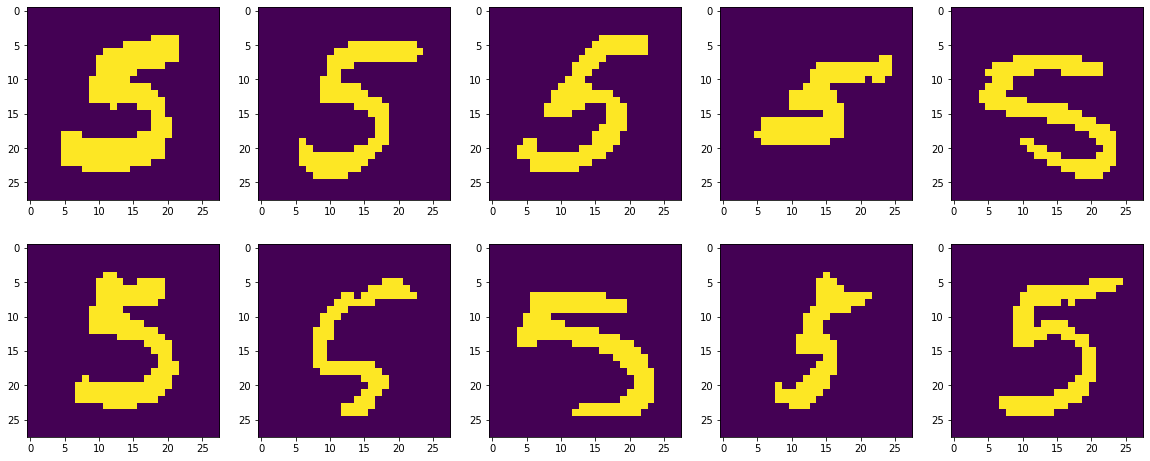

In [139]:
# Check a sample of the training images:
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(20,8))
for i,image in enumerate(np.random.choice(range(len(data_X)),size=10)):
    axes[i//5,i%5].imshow(np.array(data_X[image]).reshape((28,28)))

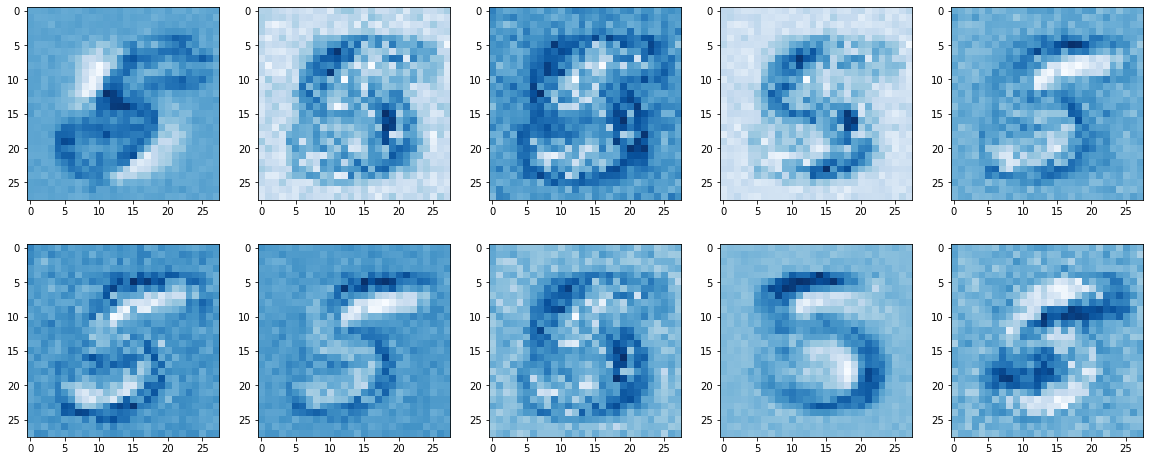

In [141]:
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(20,8))
for i,component in enumerate(model.components_[np.random.choice(len(model.components_),size=10,replace=False)]):
    axes[i//5,i%5].imshow(component.reshape((28,28)),cmap="Blues")

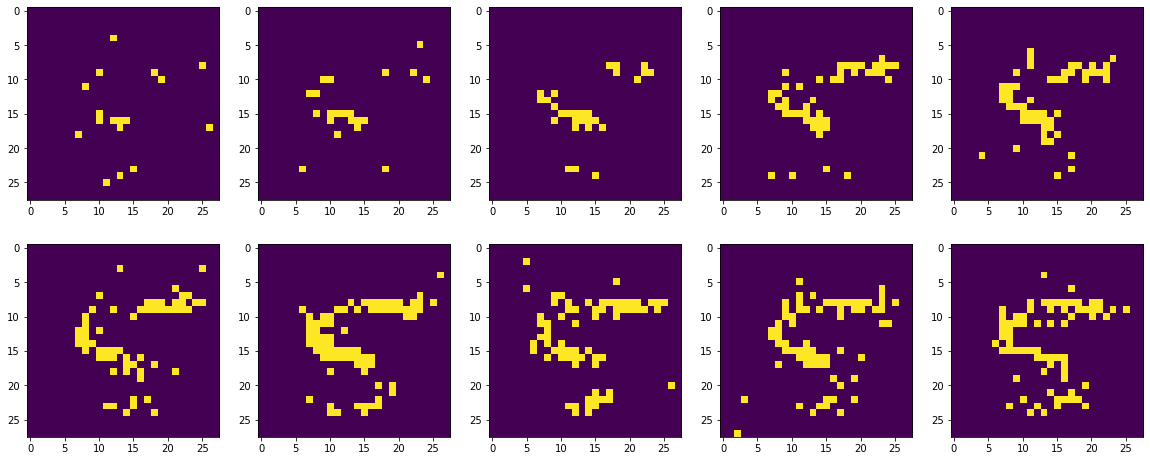

In [157]:
# Repeat Gibbs sampling for many iteraions starting from noise:
image=np.random.choice([0,1],size=784,p=[0.975,0.025])
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(20,8))
gibbs_steps=1e6
plot=0
for step in range(0,int(gibbs_steps)):
    if step%(gibbs_steps//10)==0:
        image=model.gibbs(np.array(image))
        axes[plot//5,plot%5].imshow(image.reshape((28,28)))
        plot+=1